In [18]:
import re
import unicodedata
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from env import user, password, host

In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [4]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [5]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [6]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [7]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [8]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [9]:
word_counts.sort_values(by = 'all',ascending = False)

,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
...,...,...,...
lunchtime,1,1,0
bailiff,1,0,1
lul,1,1,0
luks,1,1,0


In [10]:
word_counts.ham.value_counts().sum()

8900

In [11]:
word_counts.spam.value_counts().sum()

8900

Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

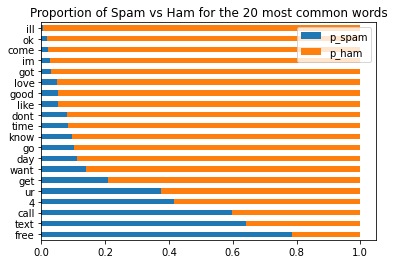

In [12]:
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [13]:
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,ham,spam,ratio
im,462,449,13,0.028953
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,279,257,22,0.085600
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


In [15]:
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
df['message_length'] = df.text.apply(len)

df['word_count'] = df.text.apply(str.split).apply(len)

df['avg_word_length'] = df.message_length / df.word_count

df.head()

,label,text,message_length,word_count,avg_word_length
id,,,,,
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,5.550000
1,ham,Ok lar... Joking wif u oni...,29,6,4.833333
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,5.535714
3,ham,U dun say so early hor... U c already then say...,49,11,4.454545
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,4.692308


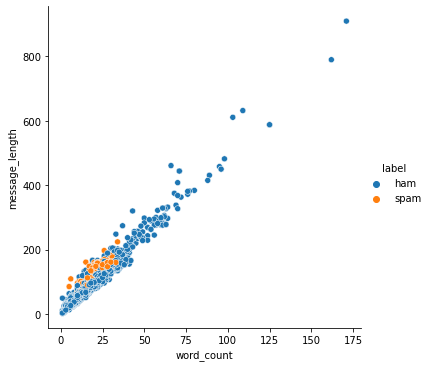

In [28]:
sns.relplot(data = df, x = 'word_count', y = 'message_length', hue = 'label')

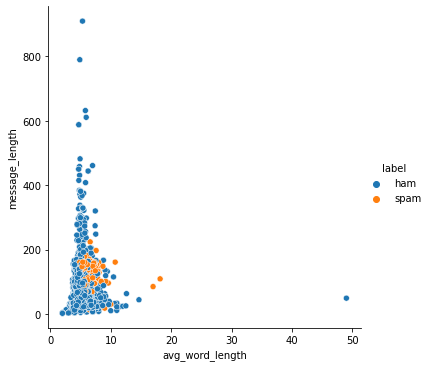

In [19]:
sns.relplot(data = df, x = 'avg_word_length', y = 'message_length', hue = 'label')

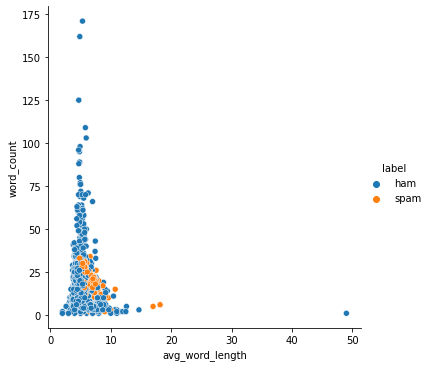

In [27]:
sns.relplot(data = df, x = 'avg_word_length', y = 'word_count', hue = 'label')

In [21]:
df.avg_word_length.idxmax()

3092

In [26]:
df[df.index == 3092].text

id
3092    staff.science.nus.edu.sg/~phyhcmk/teaching/pc1323
Name: text, dtype: object